In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os

from importlib import reload

import small_utilities
reload(small_utilities)
import Block_analysis
reload(Block_analysis)

from Block_analysis import *
from small_utilities import *

import seaborn as sns

In [2]:
def reposition_first(array):
    if len(array.shape) == 2:  # Check if it's 2D
        # Reposition first row to the last
        return np.vstack((array[1:], array[0]))
    elif len(array.shape) == 3:  # Check if it's 3D
        # Reposition first slice to the last
        return np.concatenate((array[1:], array[:1]), axis=0)

import matplotlib.pyplot as plt
import numpy as np

def plot_colvar(colvar, trj_frames, num_cvs, labels, weights=None, out_dir=None):
    """
    Plot collective variables over time with corresponding histograms and reweighted histograms.

    Parameters:
        colvar (np.ndarray): Array of collective variables with time as the first column.
        trj_frames (dict): Dictionary mapping frame indices to frame times.
        num_cvs (int): Number of collective variables.
        labels (dict): Dictionary of labels for the collective variables.
        weights (np.ndarray, optional): Normalized weights for reweighting histograms. Must match the number of frames.
        out_dir (str, optional): Directory to save the plot. If None, the plot is shown but not saved.
    """
    # Configure subplots
    height_ratios = [1] * (num_cvs - 1)
    fig, axes = plt.subplots(
        num_cvs - 1, 2, figsize=(32, 40),
        gridspec_kw={
            'width_ratios': [4, 1],
            'height_ratios': height_ratios,
            'left': 0.1, 'right': 0.9,
            'bottom': 0.1, 'top': 0.9,
            'wspace': 0.02, 'hspace': 0.2
        },
        sharey=False,
        # sharex=True
    )

    # Check if weights are provided
    if weights is not None:
        if len(weights) != colvar.shape[0]:
            raise ValueError("Weights must match the number of frames in colvar.")
        weights = weights / np.sum(weights)  # Normalize weights

    # Loop over collective variables
    for i in range(num_cvs - 1):
        time = colvar.T[0] / 10**5  # Time in appropriate units
        data = colvar.T[i + 1]  # Data for the i-th collective variable

        # Line plot of collective variable over time
        axes[i, 0].plot(time, data, color='r', label=labels.get(str(i + 1), f'CV {i + 1}'))
        axes[i, 0].set_ylabel(labels.get(str(i + 1), f'CV {i + 1}'), size=35)
        axes[i, 0].set_xlabel(r"Time ($\mu$s)", size=35)
        axes[i, 0].tick_params(labelsize=25)
        xticks=[frame_time[1] / 10**5 for frame_idx, frame_time in trj_frames.items()]

        axes[i, 0].set_xticks(xticks)

        # Add vertical lines for trajectory frames
        for frame_idx, frame_time in trj_frames.items():
            axes[i, 0].axvline(x=frame_time[1] / 10**5, color='black', linewidth=3, linestyle='--')

        # Plot histogram
        axes[i, 1].hist(data, bins=50, orientation='horizontal', density=True, color='black', histtype='step', linewidth=2)

        # Plot reweighted histogram (if weights are provided)
        if weights is not None:
            # # Compute weighted histogram
            # hist, bin_edges = np.histogram(data, bins=50, density=True, weights=weights)
            # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            # axes[i, 1].plot(hist, bin_centers, color='green', linewidth=2, label='Reweighted')
            axes[i, 1].hist(data, bins=50, orientation='horizontal', density=True, color='green', histtype='step', linewidth=2, weights=weights)


        axes[i, 1].tick_params(labelsize=25)
        axes[i, 1].set_yticks([])

    # Save or display the plot
    if out_dir:
        plt.savefig(f"{out_dir}/cv_plot.png", dpi=310, bbox_inches='tight')
    else:
        plt.show()

def create_trj_frames(colvar_data, nreps=16):
    """
    Create trajectory frame intervals based on the given data.

    Parameters:
        colvar_data (list): A list or array-like structure containing the data.
        nreps (int): Number of intervals (default is 16).
        index (int): Index of the dataset to process (default is 100).

    Returns:
        dict: A dictionary where keys are strings of interval indices and values are lists of start and end points.
    """
    # Determine the total length and calculate interval size
    total_frames = colvar_data.shape[0] - 1
    interval_size = total_frames / nreps

    # Initialize variables
    a, b = 0, interval_size
    trj_frames = {}

    # Create intervals
    for i in range(nreps):
        trj_frames[str(i)] = [a, b]
        a = b
        b += interval_size

    return trj_frames

## Analysis for $\alpha$-synuclien with Fasudil (Trajectory-2)

### Loading the data

The colvar files are generated from the concatinated trajectories at the respective time intervels. For example, $100ns$ for each replica trajectory is obtained and concatinated togeather, which is used to compute the weights. 

In [3]:
work_directory = os.getcwd()
a = np.sort([i for i in os.listdir(work_directory) if os.path.isdir(i)])

print(f'Current working dir: \n{work_directory}\n')
print(f'which has the following directories: \n{a}')

Current working dir: 
/Users/jayakrishnakoneru/Documents/work/plots_now/PBMetaD

which has the following directories: 
['fas_1' 'fas_2' 'lig47_1' 'lig47_2']


In [4]:
colvar_data={}
weights_norm={}

for i in range(0,1000, 100):

    if i==0:
        colvar_data[i+1000]=np.loadtxt(f'{work_directory}/{a[1]}/colvar/colvar_{i}.dat', comments=['#','@'])
        num_cvs, _, weights_norm[i+1000] = norm_weights(f'{work_directory}/{a[2]}/colvar/colvar_{i}.dat')
        print(f"Sum of combined xtc weights : {np.sum(weights_norm[i+1000])}")
        print(f"Number of frames : {colvar_data[i+1000].shape[0]}")
    else:
            
        colvar_data[i]=np.loadtxt(f'{work_directory}/{a[1]}/colvar/colvar_{i}.dat', comments=['#','@'])
        num_cvs, _, weights_norm[i] = norm_weights(f'{work_directory}/{a[2]}/colvar/colvar_{i}.dat')

        print(f"Sum of combined xtc weights : {np.sum(weights_norm[i])}")
        print(f"Number of frames : {colvar_data[i].shape[0]}")
    


Sum of combined xtc weights : 1.0000000000000007
Number of frames : 1600001
Sum of combined xtc weights : 1.0
Number of frames : 160001
Sum of combined xtc weights : 1.0
Number of frames : 320001
Sum of combined xtc weights : 0.9999999999999998
Number of frames : 480001
Sum of combined xtc weights : 1.0
Number of frames : 640001
Sum of combined xtc weights : 1.0000000000000009
Number of frames : 800001
Sum of combined xtc weights : 0.9999999999999991
Number of frames : 960001
Sum of combined xtc weights : 0.9999999999999991
Number of frames : 1120001
Sum of combined xtc weights : 1.0000000000000002
Number of frames : 1280001
Sum of combined xtc weights : 0.9999999999999999
Number of frames : 1440001


### Plot for 100ns data (1600ns(1.6 $\mu$ s) aggregate time.)

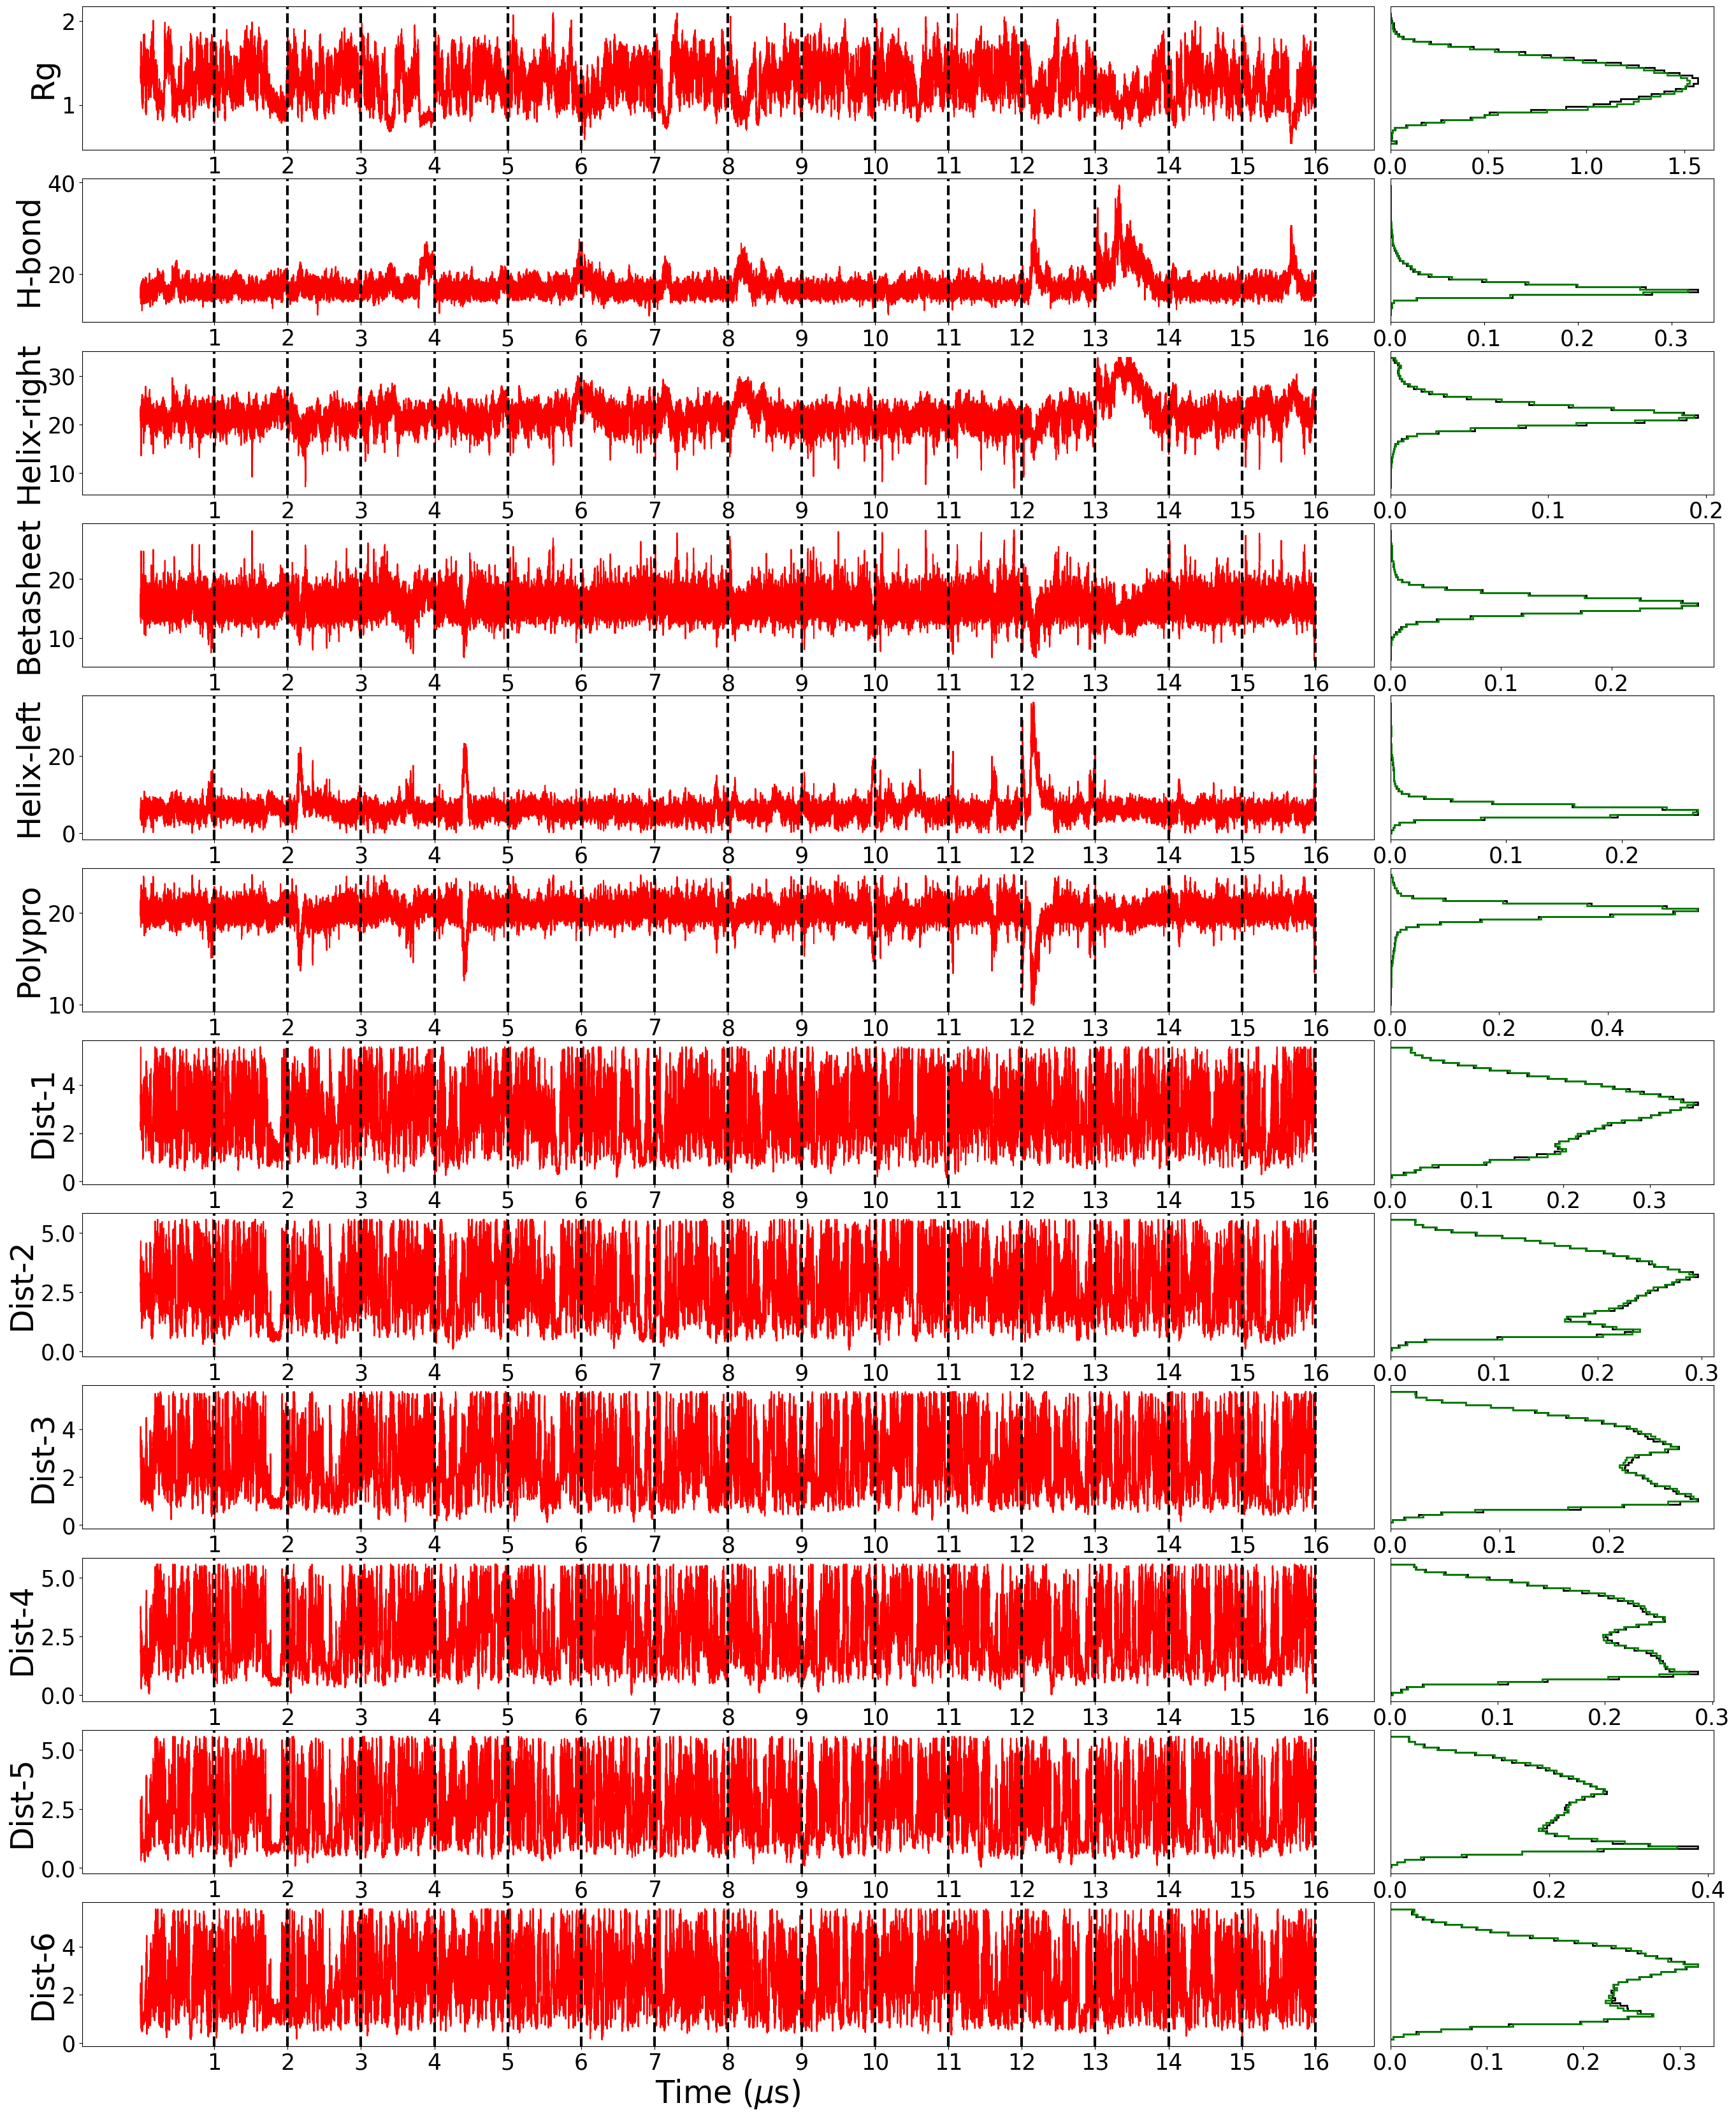

In [5]:
label={
    '1':'Rg', '2':'H-bond', '3':'Helix-right', '4':'Betasheet', '5':'Helix-left', '6':'Polypro',
    '7':'Dist-1', '8':'Dist-2', '9':'Dist-3', '10':'Dist-4', '11':'Dist-5', '12':'Dist-6'
       }

# change the value of index from 100 to 1000 to see the plot for the different aggregate data
index=1000
trj_frames=create_trj_frames(colvar_data[index])

plot_colvar(colvar_data[index], trj_frames, num_cvs, labels=label, weights=weights_norm[index])

In [6]:
index_dict={
    'Rg':1, 'H-bond':2, 'Helix-right':3, 'Betasheet':4, 'Helix-left':5, 'Polypro':6,
    'Dist-1':7, 'Dist-2':8, 'Dist-3':9, 'Dist-4':10, 'Dist-5':11, 'Dist-6':12
       }

### Free energy plot of Rg computed plotted from the respective colver files

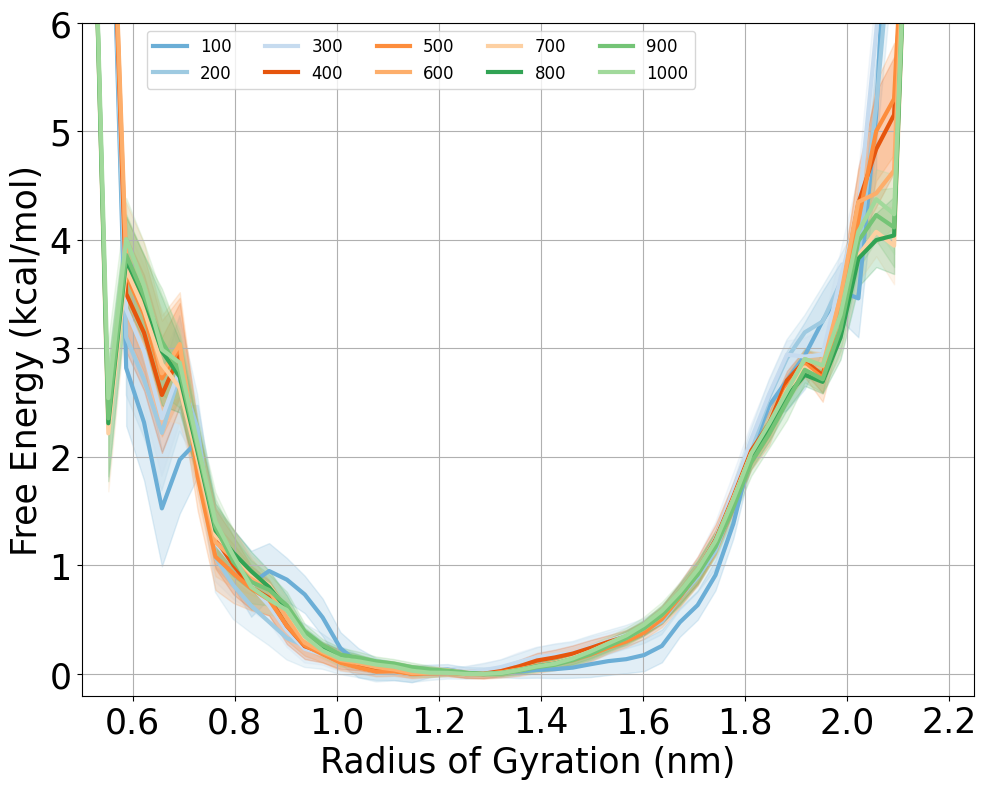

In [7]:
np.seterr(invalid='ignore')

plt.figure(figsize=(10,8))

for i in range(100,1100, 100):
    dG1, bin_centers, ferr = free_energy_1D_blockerror(colvar_data[i].T[index_dict['Rg']], T=300, x0=0.5, xmax=2.25, bins=50, blocks=5, weights=weights_norm[i])

    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

plt.ylim(-0.2, 6)
plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()

In [8]:
mean_rg=np.zeros((10,2))
# mean_rg_err=np.zeros(10)

for i in range(100,1100, 100):
    # print(f'{i} : {get_blockerror_pyblock_nanskip_rw_(colvar_data[i].T[1], weights_norm[i])}')
    mean_rg[int(i/100)-1]=get_blockerror_pyblock_nanskip_rw_(colvar_data[i].T[index_dict['Rg']], weights_norm[i])

mean_rg

array([[1.29728942, 0.02653512],
       [1.24085476, 0.03351081],
       [1.2428989 , 0.02353631],
       [1.24897522, 0.02338562],
       [1.25231742, 0.02076218],
       [1.25781953, 0.02161791],
       [1.26167808, 0.01646952],
       [1.26373566, 0.01638583],
       [1.2674965 , 0.01647375],
       [1.25768532, 0.01814786]])

### $<Rg>$ plotted against aggregate time

Text(0, 0.5, '<Rg> (nm)')

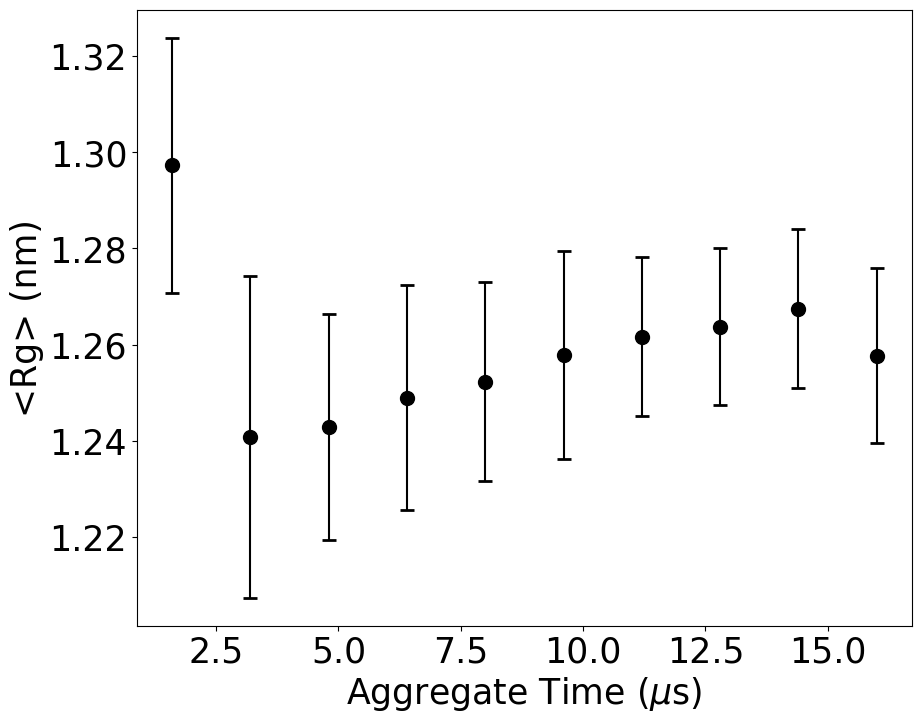

In [9]:
plt.figure(figsize=(10,8))

plt.errorbar(np.arange(0.1,1.1,0.1)*16, mean_rg.T[0], yerr=mean_rg.T[1], fmt='o', color='black', markersize=10, capsize=5, capthick=2)

plt.tick_params(labelsize=25)
plt.xlabel(r'Aggregate Time ($\mu$s)', size=25)
plt.ylabel(r'<Rg> (nm)', size=25)


### Free energy for 6 distances computed between protein and small molecule

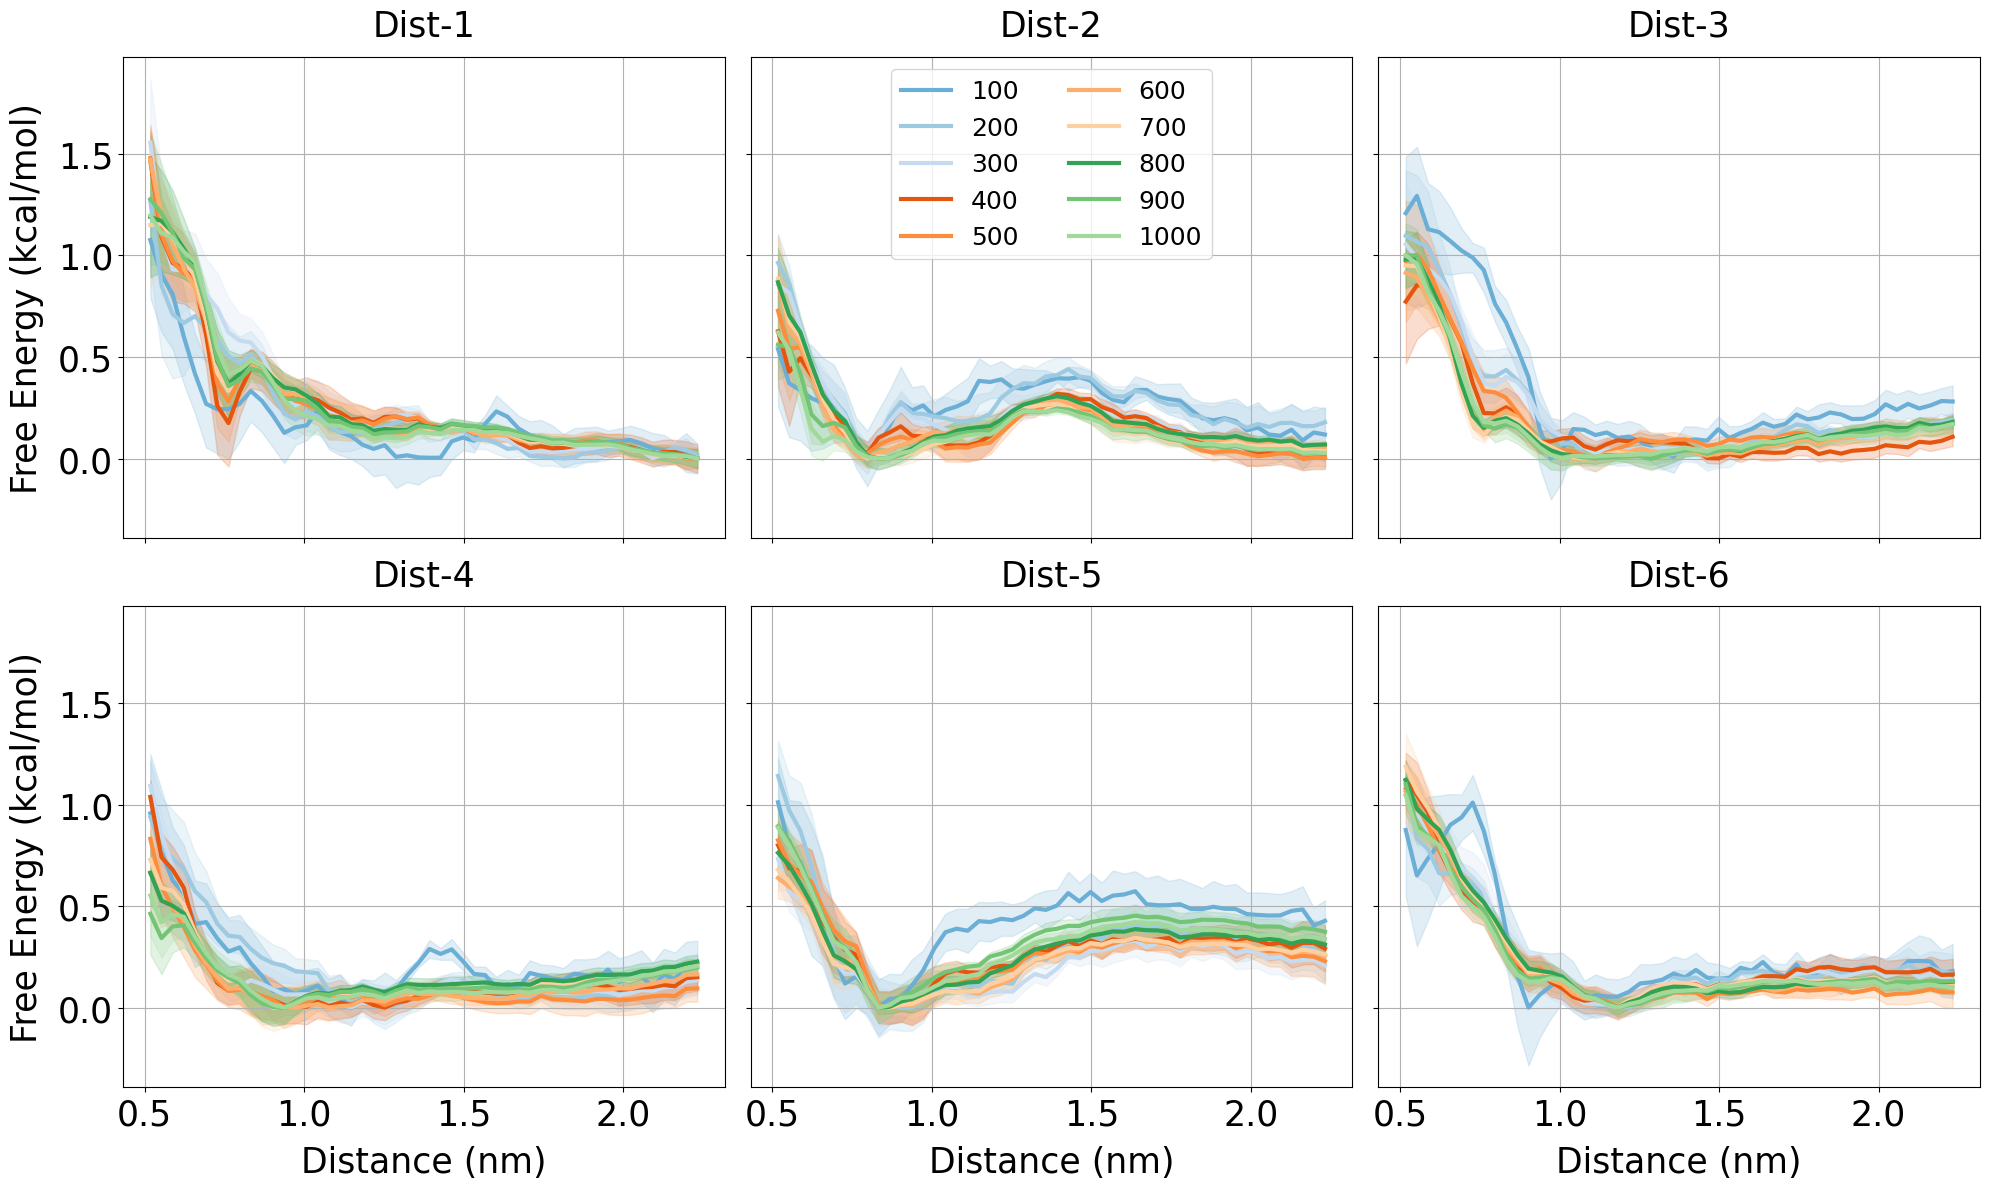

In [10]:
np.seterr(invalid='ignore')

fig, ax = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)

for d in range(0,6):

    p,q = np.unravel_index(d,(2,3))

    for i in range(100,1100, 100):
        dG1, bin_centers, ferr = free_energy_1D_blockerror(colvar_data[i].T[d+7], T=300, x0=0.5, xmax=2.25, bins=50, blocks=5, weights=weights_norm[i])

        sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i), linestyle='-', ax=ax[p,q])
        ax[p,q].fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

    ax[p,q].tick_params(labelsize=25)
    # ax[p,q].set_ylim(-0.2, 2)
    # ax[p,q].set_xlim(0.5, 2.25)
    ax[p,q].set_xlabel(f'Distance (nm)', size=25, labelpad=10)
    ax[p,q].set_ylabel('Free Energy (kcal/mol)', size=25, labelpad=10)
    if p==0 and q==1 : ax[p,q].legend(loc='upper center', fontsize=18, ncol=2)
    else : ax[p,q].legend().set_visible(False)
    ax[p,q].set_title(f'Dist-{d+1}', size=25, pad=15)
    ax[p,q].grid()


plt.tight_layout()


### Weighted average of distance plotted against aggregate time

In [11]:
mean_dist=np.zeros((6,10,2))
# mean_rg_err=np.zeros(10)

for d in range(0,6):
        
    for i in range(100,1100, 100):
        # print(f'{i} : {get_blockerror_pyblock_nanskip_rw_(colvar_data[i].T[1], weights_norm[i])}')
        mean_dist[d][int(i/100)-1]=get_blockerror_pyblock_nanskip_rw_(colvar_data[i].T[d+7], weights_norm[i])





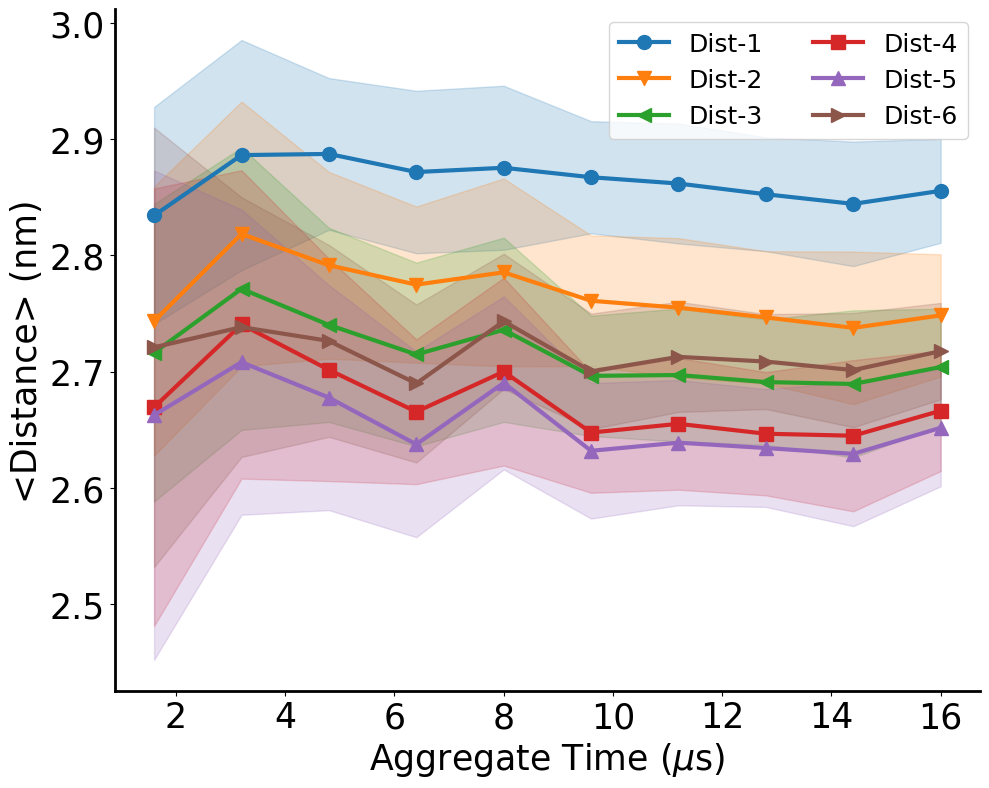

In [12]:
marker=['o','v','<', 's','^','>']

fig, ax = plt.subplots(figsize=(10,8))  # Create a figure and an axes

for d in range(0,6):
    # plt.errorbar(np.arange(0.1,1.1,0.1)*16, mean_dist[d].T[0], yerr=mean_dist[d].T[1], fmt='o', color=plt.cm.tab10(d), markersize=10, capsize=5, capthick=2, label=f'Dist-{d+1}')
    ax.plot(np.arange(0.1,1.1,0.1)*16, mean_dist[d].T[0], color=plt.cm.tab10(d), linewidth=3, label=f'Dist-{d+1}', marker=marker[d], markersize=10)
    ax.fill_between(np.arange(0.1,1.1,0.1)*16, mean_dist[d].T[0]-mean_dist[d].T[1], mean_dist[d].T[0]+mean_dist[d].T[1], color=plt.cm.tab10(d), alpha=0.2)

ax.tick_params(labelsize=25)
ax.set_xlabel(r'Aggregate Time ($\mu$s)', size=25)
ax.set_ylabel(r'<Distance> (nm)', size=25)
ax.legend(fontsize=18, ncol=2)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)

plt.tight_layout()

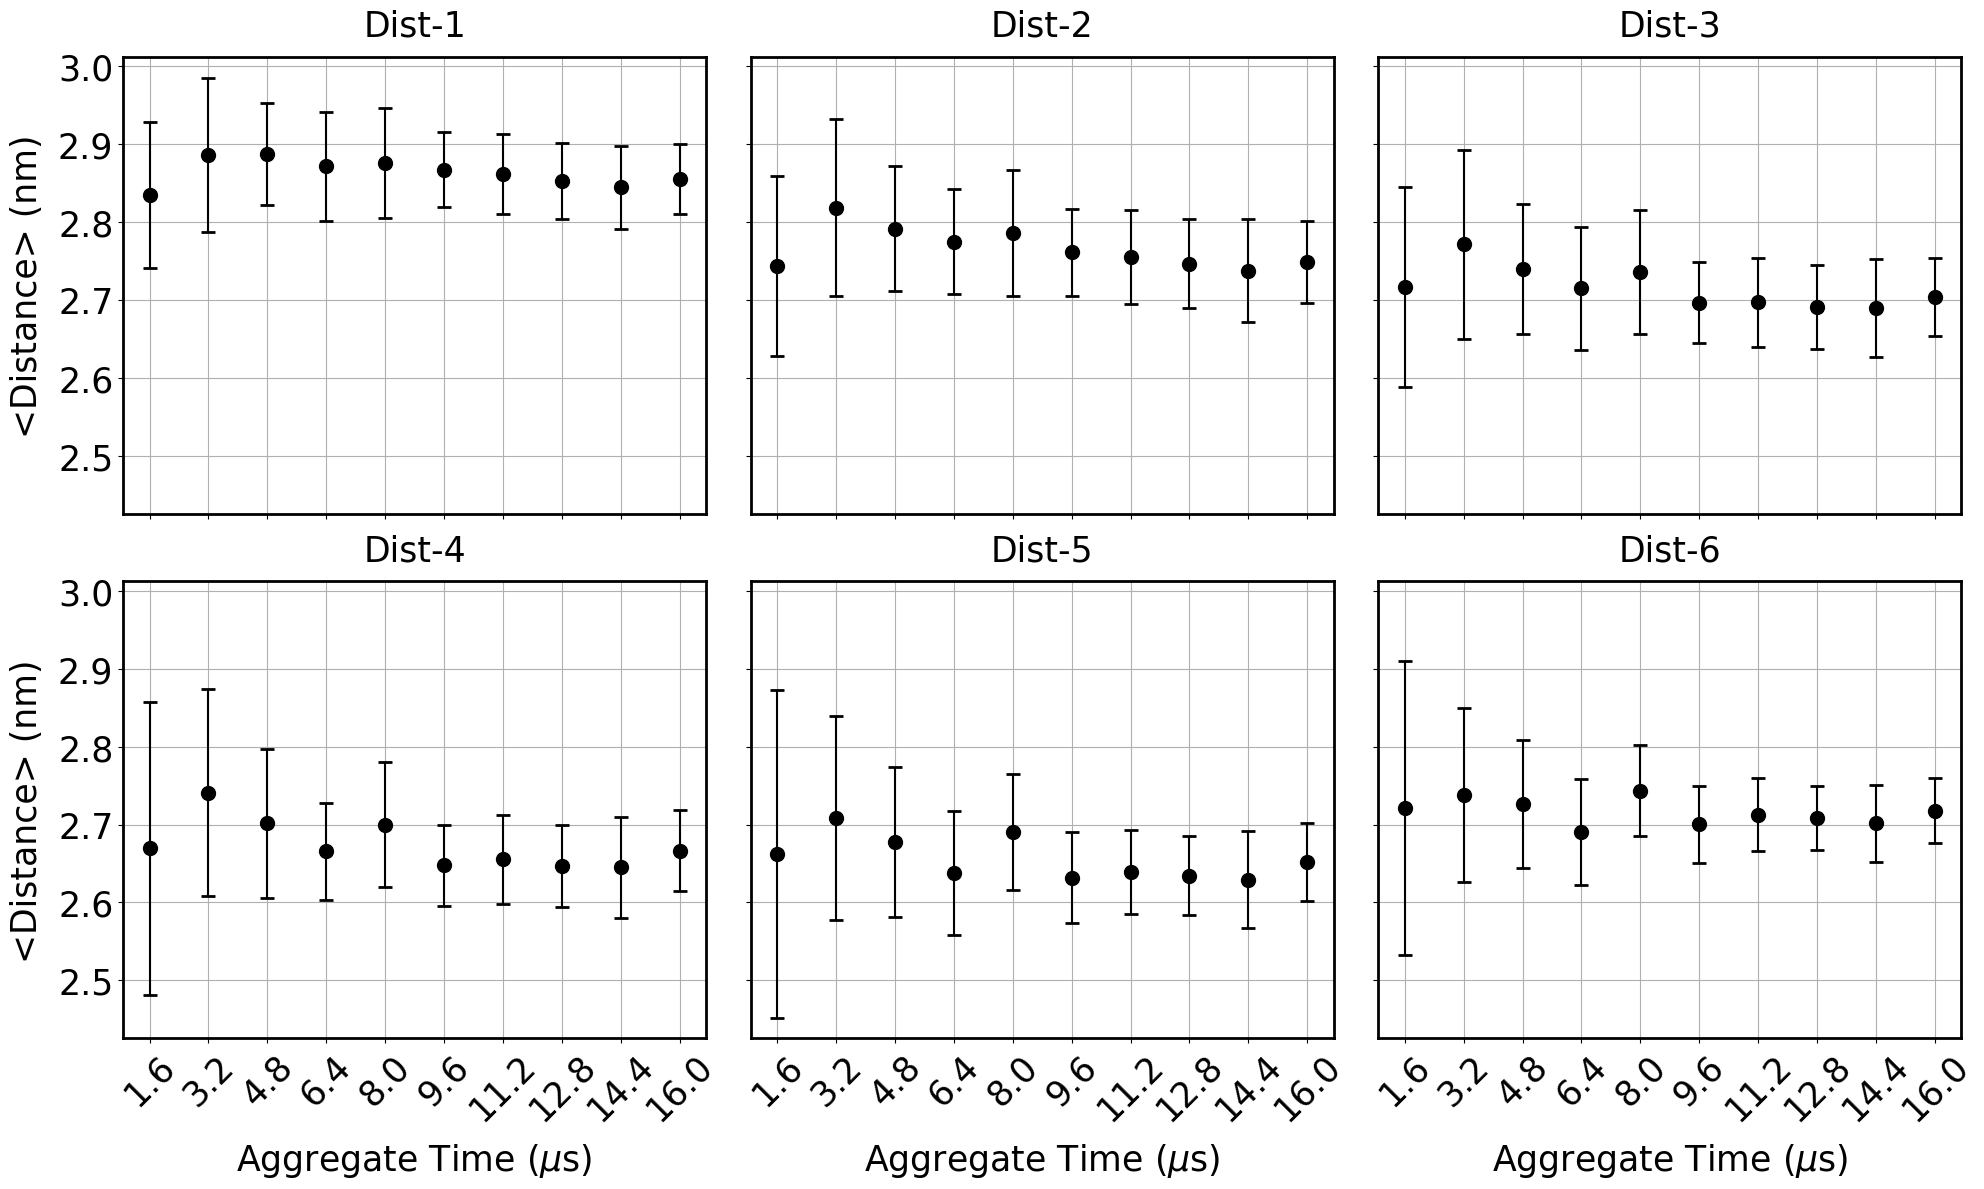

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)

for d in range(0,6):

    p,q = np.unravel_index(d,(2,3))

    ax[p,q].errorbar(np.arange(0.1,1.1,0.1)*16, mean_dist[d].T[0], yerr=mean_dist[d].T[1], fmt='o', color='black', markersize=10, capsize=5, capthick=2)


    ax[p,q].tick_params(labelsize=25)
    # ax[p,q].set_ylim(-0.2, 2)
    # ax[p,q].set_xlim(0.5, 2.25)
    if p==1 : ax[p,q].set_xlabel(r'Aggregate Time ($\mu$s)', size=25, labelpad=10)
    if q==0 :ax[p,q].set_ylabel(r'<Distance> (nm)', size=25, labelpad=10)

    ax[p,q].set_title(f'Dist-{d+1}', size=25, pad=15)
    ax[p,q].grid()
    ax[p,q].spines['right'].set_linewidth(2)
    ax[p,q].spines['left'].set_linewidth(2)
    ax[p,q].spines['top'].set_linewidth(2)
    ax[p,q].spines['bottom'].set_linewidth(2)

    ax[p,q].set_xticks(np.arange(0.1,1.1,0.1)*16,[round(i,1) for i in np.arange(0.1,1.1,0.1)*16],rotation=45)


plt.tight_layout()


In [14]:
sequence=  ['ASP121', 'ASN122', 'GLU123', 'ALA124', 'TYR125', 'GLU126', 'MET127', 'PRO128', 'SER129', 'GLU130', 'GLU131', 'GLY132', 'TYR133', 'GLN134', 'ASP135',
'TYR136', 'GLU137', 'PRO138', 'GLU139', 'ALA140']

ticks_pnum , ticks_pname = sequence_ticks_1(sequence)


In [15]:
file_name = 'l_contact_map_re.json'

# lcm_fas_1 = []
lcm_fas_2 = []
# lcm_lig47_1 = []
# lcm_lig47_2 = []

for i in range(0, 1000, 100):
    # lcm_fas_1.append(load_json(f'{work_directory}/{a[0]}/data/out_{i}/{file_name}'))
    lcm_fas_2.append(load_json(f'{work_directory}/{a[1]}/data/out_{i}/{file_name}'))
    # lcm_lig47_1.append(load_json(f'{work_directory}/{a[2]}/data/out_{i}/{file_name}'))
    # lcm_lig47_2.append(load_json(f'{work_directory}/{a[3]}/data/out_{i}/{file_name}'))

# lcm_fas_1 = np.array([lcm_fas_1[i]['0'] for i in range(len(lcm_fas_1))])
# lcm_fas_1 = reposition_first(lcm_fas_1)

lcm_fas_2 = np.array([lcm_fas_2[i]['0'] for i in range(len(lcm_fas_2))])
lcm_fas_2 = reposition_first(lcm_fas_2)

# lcm_lig47_1 = np.array([lcm_lig47_1[i]['0'] for i in range(len(lcm_lig47_1))])
# lcm_lig47_1 = reposition_first(lcm_lig47_1)

# lcm_lig47_2 = np.array([lcm_lig47_2[i]['0'] for i in range(len(lcm_lig47_2))])
# lcm_lig47_2 = reposition_first(lcm_lig47_2)

Text(0.5, 0.93, '$\\alpha$-synuclein C-term :Fasudil')

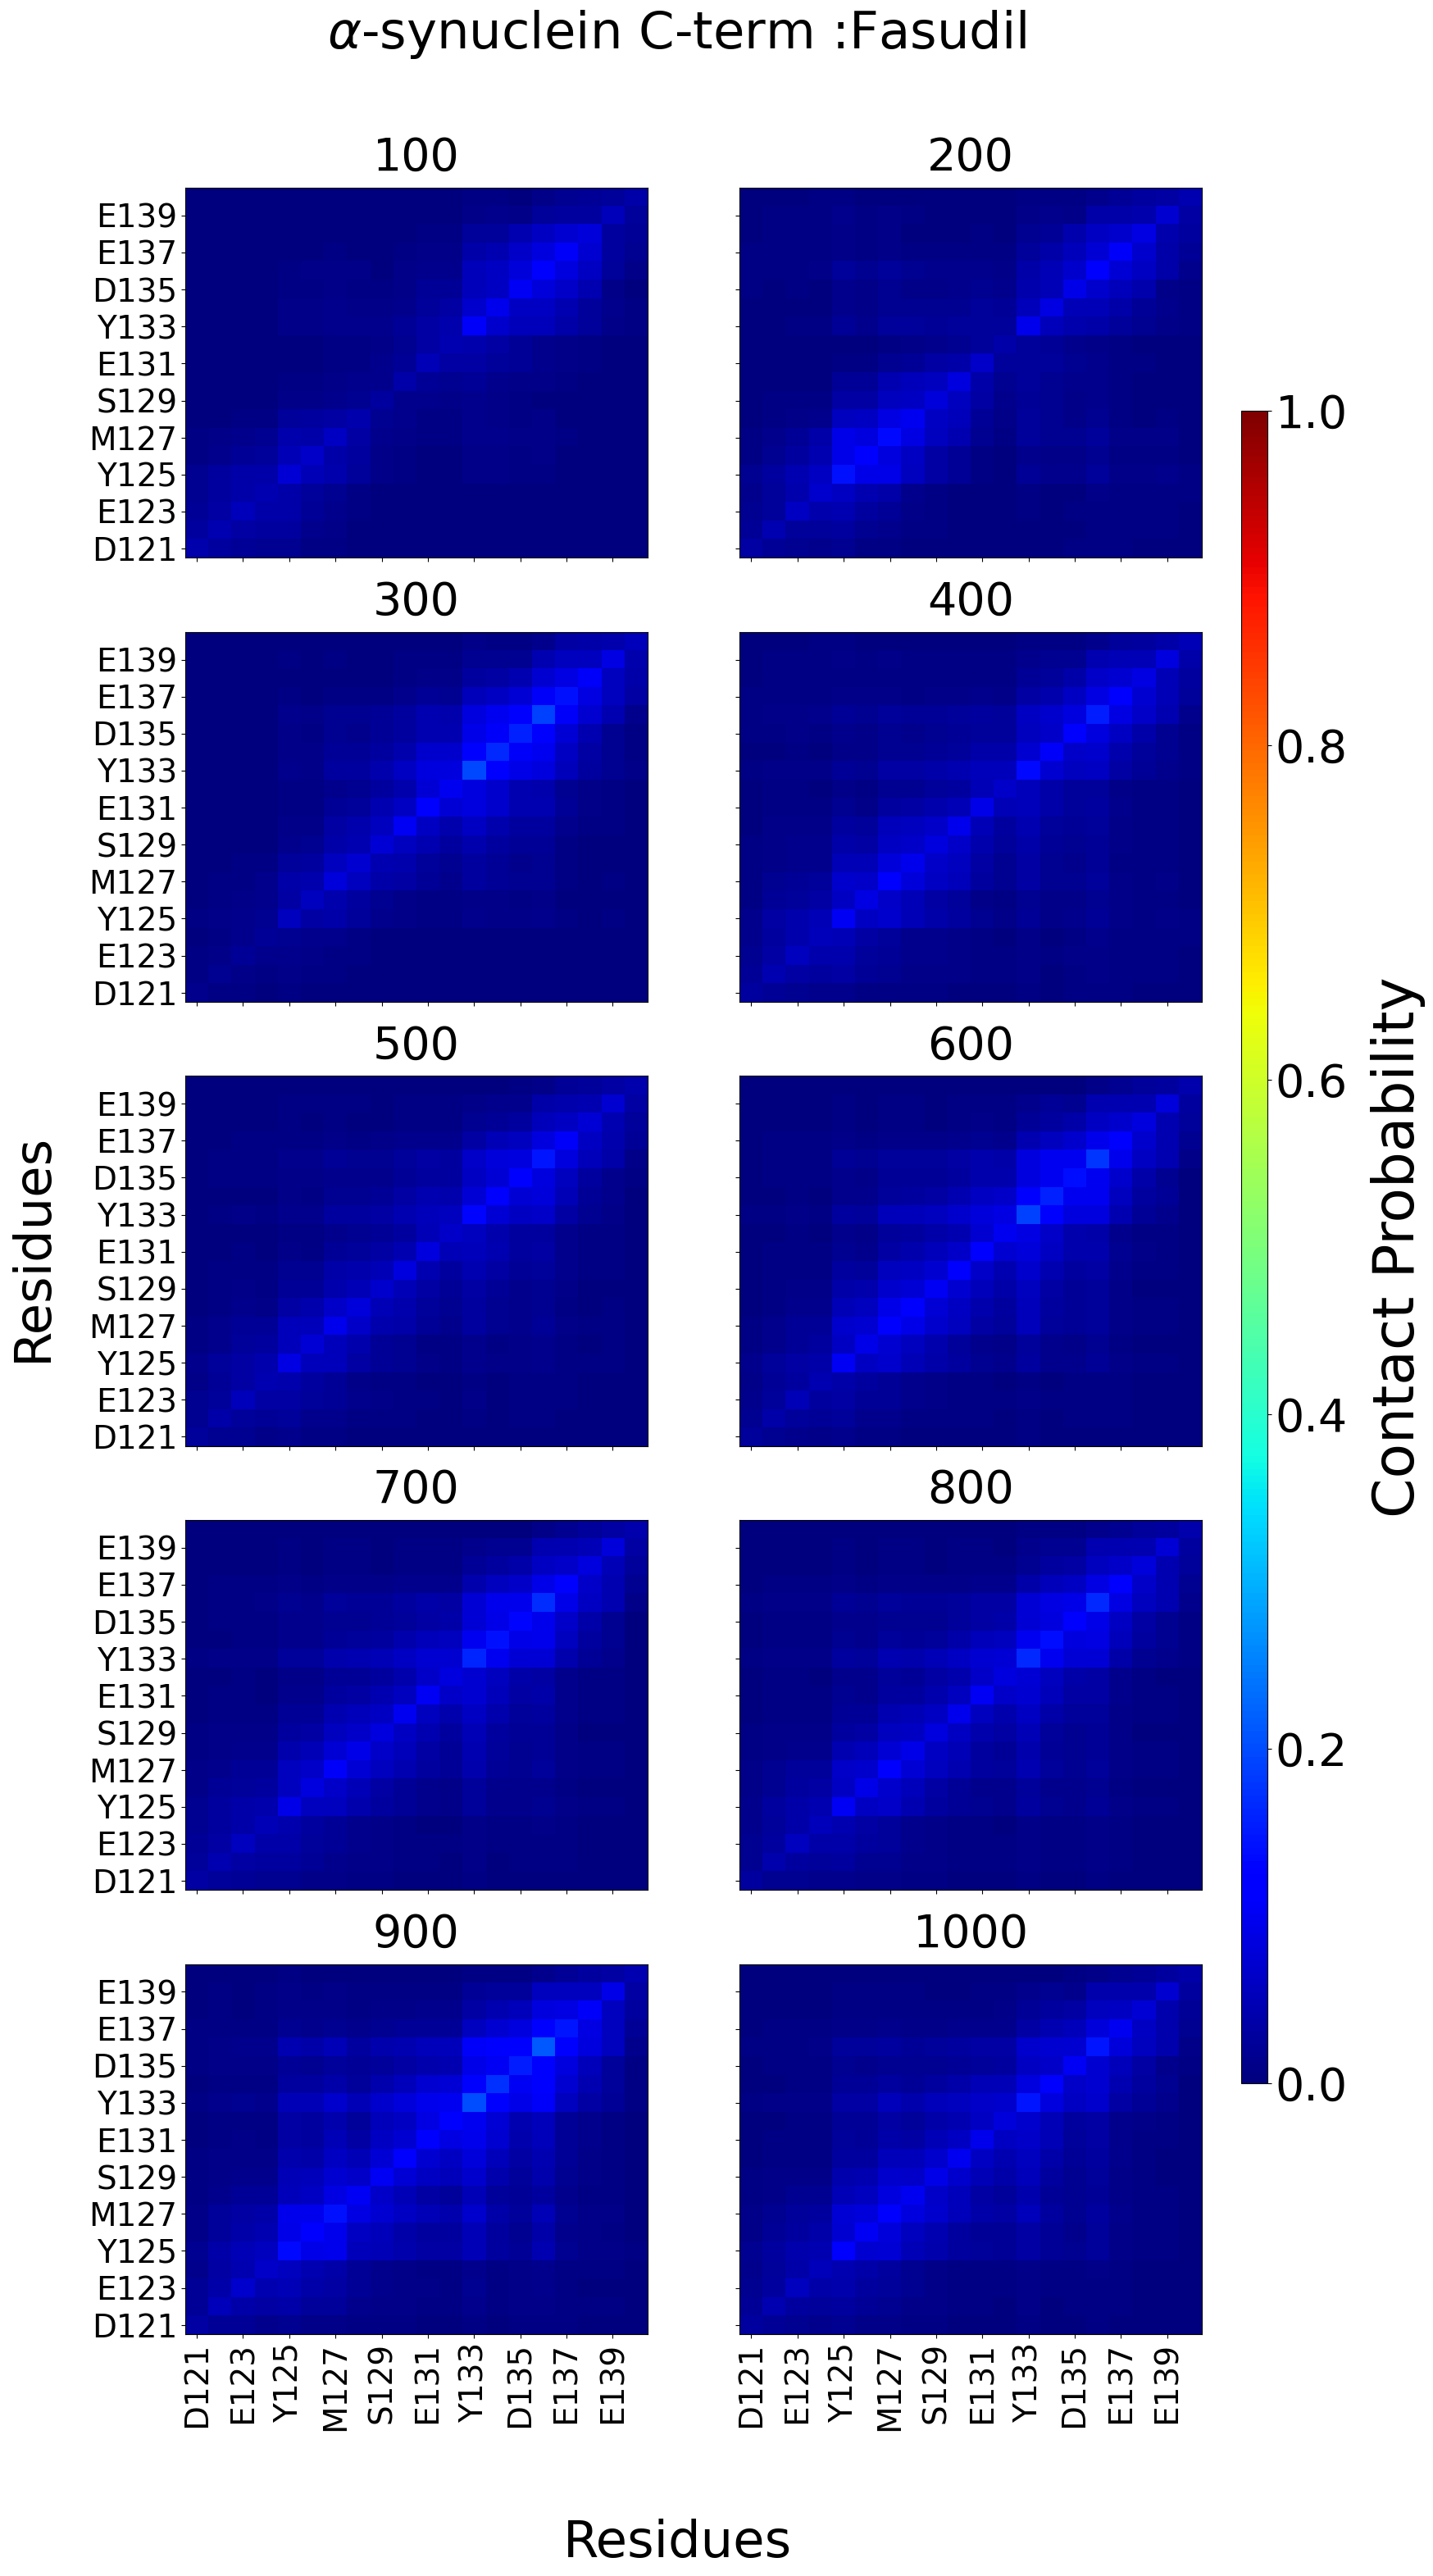

In [16]:
# from mpl_toolkits.axes_grid1 import AxesGrid

fig, axes = plt.subplots(5,2, figsize=(16,34), sharex=True, sharey=True)
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])
     

images=[]
for i in range(0, 10):
    # ax.set_axis_off()

    contact_map = np.array(lcm_fas_2[i])

    
    p,q = np.unravel_index(i,(5,2))

    im = axes[p,q].imshow(contact_map, vmin=0, vmax=1.0,cmap='jet', aspect='auto')
    axes[p,q].invert_yaxis()
    axes[p,q].set_xticks(range(0, 20,2), ticks_pnum[::2], rotation=90, size=28)
    axes[p,q].set_yticks(range(0, 20,2), ticks_pnum[::2], rotation=0, size=28)
    axes[p,q].grid(False)
    axes[p,q].set_title(f'{(i*100)+100}',size=40, pad=15)

    # if not q : axes[p,q].set_ylabel("Residues", size=45, labelpad=15)
    # if p == 2-1 : axes[p,q].set_xlabel('Residues', size=45, labelpad=15)
    images.append(im)

for ax in axes.flat :

    if not bool(ax.has_data()):

        fig.delaxes(ax)

# cbar = fig.colorbar(images[-1],cax=cax, orientation="horizontal")
cbar = fig.colorbar(images[-1],cax=cax)

cbar.set_label("Contact Probability", size=50, labelpad=20)
cbar.ax.tick_params(labelsize=40)
# cbar.set_ticks([])
# cbar.set_ticklabels([])

fig.text(0.5, 0.03, "Residues", ha="center", fontsize=45)
fig.text(-0.01, 0.5, "Residues", va="center", rotation="vertical", fontsize=45)

# plt.suptitle("Protein:protien contact matix",size=50 )
fig.text(0.5, 0.93, r'$\alpha$-synuclein C-term :Fasudil', ha="center", fontsize=45)

# plt.grid(alpha=0.1)
# plt.tight_layout()
# plt.savefig(f"{out_dir}/p_cm.png", dpi=1000, bbox_inches='tight')
# plt.savefig(f"{out_dir}/p_cm.pdf", dpi=1200, bbox_inches='tight')
# plt.savefig(f"{out_dir}/p_cm.eps", dpi=1200, bbox_inches='tight')

# plt.show()
# plt.clf()
